# Fine-Tuning GPT for Text Classification (Spam Detection)

## Introduction: What is Fine-Tuning and Why Does It Work?

This notebook demonstrates one of the most powerful techniques in modern deep learning: **fine-tuning a pre-trained language model** for a specific task.

### The Core Idea: Transfer Learning

Imagine you want to teach someone to identify spam emails. Would you:
- **Option A**: Start with a newborn baby and teach them everything from scratch (language, reading, what email is, what spam looks like...)
- **Option B**: Start with an educated adult who already understands language, and just teach them what spam looks like

Obviously Option B is faster and more effective. **Fine-tuning is Option B for neural networks.**

### How Pre-training Creates Useful Knowledge

GPT-2 was pre-trained on ~40GB of internet text using a simple task: **predict the next word**. But this simple task forced the model to learn incredibly rich knowledge:

```
To predict what comes next in "The capital of France is ___"
The model must KNOW that Paris is the capital of France.

To predict what comes next in "She was feeling sad, so she ___"
The model must UNDERSTAND human emotions and typical responses.

To predict what comes next in "The function returns None if ___"
The model must COMPREHEND programming concepts.
```

### Why Fine-Tuning Works So Well

| Aspect | Training from Scratch | Fine-Tuning Pre-trained |
|--------|----------------------|------------------------|
| **Data needed** | Millions of examples | Hundreds to thousands |
| **Compute cost** | Days/weeks on GPUs | Minutes to hours |
| **Performance** | Often worse | Often better! |
| **Why?** | Must learn language + task | Language already learned |

The pre-trained model has learned a **general-purpose representation of language**. Fine-tuning just teaches it to use this representation for our specific task.

### What We'll Build

A **spam classifier** that takes any text message and predicts:
- `0` = ham (legitimate message)  
- `1` = spam (unwanted/scam message)

### Learning Objectives

By the end of this notebook, you will understand:

1. **Data Preparation**: Why class balance matters and how to handle it
2. **Transfer Learning**: How to leverage pre-trained models effectively
3. **Model Adaptation**: How to modify a language model for classification
4. **Selective Fine-Tuning**: Why we freeze some layers and train others
5. **Training Dynamics**: How to monitor and interpret training progress

---

## Install Dependencies

We need three key libraries:
- **PyTorch**: Deep learning framework for model training
- **tiktoken**: OpenAI's fast tokenizer (same one GPT-2 uses)
- **transformers**: Hugging Face library (useful utilities)

In [1]:
!pip install torch tiktoken transformers

## Part 1: Getting the Data

### Why Data Quality Matters More Than Model Size

Before we touch any model code, we need good data. In machine learning, there's a saying: **"Garbage in, garbage out."** The best model in the world can't learn from bad data.

### The SMS Spam Collection Dataset

We'll use a classic dataset from the UCI Machine Learning Repository containing **5,574 real SMS messages** labeled as "ham" (legitimate) or "spam".

#### Why This Dataset is Good for Learning:

| Property | Benefit |
|----------|---------|
| **Real messages** | Not synthetic - actual patterns spammers use |
| **Binary labels** | Simple ham/spam makes concepts clear |
| **Moderate size** | Large enough to learn, small enough to train fast |
| **Well-studied** | We can compare our results to published benchmarks |

### The Download Function Explained

Our download function does several things:

```python
def download_and_unzip_spam_data(...):
    # 1. CHECK IF ALREADY EXISTS
    # Why? Avoid re-downloading 5MB every time you run the notebook
    if data_file_path.exists():
        return
    
    # 2. DOWNLOAD THE ZIP FILE
    # The data comes compressed to save bandwidth
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    
    # 3. EXTRACT THE CONTENTS
    # Unzip to get the actual text file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    
    # 4. RENAME WITH PROPER EXTENSION
    # Original file has no extension; adding .tsv helps tools recognize it
    os.rename(original_file_path, data_file_path)
```

This pattern (check-download-extract-rename) is common in ML pipelines and makes notebooks reproducible.

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path
import torch
import torch.nn as nn

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              "and extraction."
        )
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


## Exploring the Data: First Look

### Why Data Exploration is Critical

Before training any model, you MUST understand your data. Common issues that can ruin a project:
- Missing values
- Encoding errors  
- Mislabeled examples
- Unexpected distributions

### Loading with Pandas

We use `pd.read_csv()` with specific parameters:

```python
df = pd.read_csv(
    data_file_path,
    sep="\t",        # Tab-separated, not comma-separated
    header=None,      # No header row in this file
    names=["Label", "Text"]  # We provide column names
)
```

#### Why Tab-Separated?
SMS messages often contain commas! If the file used commas as separators, a message like "Hey, how are you?" would be split incorrectly. Tabs are safer delimiters.

### What to Look For

When you display `df`, examine:

1. **Data types**: Are Label and Text both strings? ✓
2. **Missing values**: Any NaN entries? (None in this dataset)
3. **Sample messages**: Do they look like real SMS? ✓
4. **Label format**: Exactly "ham" and "spam"? (Case sensitive!)

### Sample Messages You'll See

**Typical Ham:**
```
"Ok lar... Joking wif u oni..."
"Cos i was out shopping wif darren jus now n]..."
```

**Typical Spam:**
```
"Free entry in 2 a wkly comp to win FA Cup final..."
"WINNER!! As a valued network customer you have been selected..."
```

Notice spam often has: ALL CAPS, exclamation marks!!!, promises of prizes, urgent calls to action.

In [3]:
import pandas as pd
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Understanding Class Imbalance: A Critical Concept

#### What is Class Imbalance?

When one class has significantly more examples than another, we have **class imbalance**. Let's see the distribution:

```
ham     4825    (87%)
spam     747    (13%)
```

This 87/13 split reflects reality - most messages are legitimate! But it creates a problem for machine learning.

#### Why Imbalance is Dangerous

Imagine a lazy model that ALWAYS predicts "ham" regardless of input:

```python
def lazy_model(message):
    return "ham"  # Always predict ham
```

This terrible model achieves **87% accuracy**! The metrics look good, but the model is useless - it can't detect any spam.

#### The Accuracy Paradox

| Model | Spam Detection | Ham Detection | Accuracy |
|-------|---------------|---------------|----------|
| Always predict "ham" | 0% | 100% | 87% |
| Random guessing | 50% | 50% | 50% |
| **Good classifier** | 95% | 95% | 95% |

High accuracy alone doesn't mean your model works! This is why we'll balance the dataset.

#### Real-World Impact

In spam detection, missing a spam message (false negative) is annoying, but classifying a legitimate message as spam (false positive) could mean missing an important message from a friend or family member. Understanding these tradeoffs is crucial.

In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


## Balancing the Dataset: Making Fair Training Possible

### The Problem with Imbalanced Training

During training, the model sees many more ham examples than spam. This causes:

1. **Gradient Domination**: Ham examples contribute more to weight updates
2. **Decision Boundary Shift**: Model becomes biased toward predicting ham
3. **Poor Minority Learning**: Not enough spam examples to learn the pattern

### Balancing Strategies Compared

| Strategy | How It Works | Pros | Cons |
|----------|--------------|------|------|
| **Downsampling** | Remove majority examples | Simple, no duplicates | Lose potentially useful data |
| **Upsampling** | Duplicate minority examples | Keep all data | Can cause overfitting on duplicates |
| **SMOTE** | Create synthetic minority examples | More data, no exact duplicates | Synthetic ≠ real, complex |
| **Class weights** | Weight loss function | Keep all data, no duplicates | Harder to tune correctly |

### Why We Choose Downsampling

For this tutorial, downsampling is ideal because:
1. **Simplicity**: Easy to understand and implement
2. **No overfitting risk**: No duplicate examples to memorize
3. **Still enough data**: 747 × 2 = 1,494 examples is plenty for fine-tuning
4. **Balanced batches**: Every batch has ~equal ham and spam

### The Balancing Code Explained

```python
def create_balanced_dataset(df):
    # Count spam examples (the minority class)
    num_spam = df[df["Label"] == "spam"].shape[0]  # 747
    
    # Randomly sample the SAME NUMBER of ham examples
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam,           # Take exactly 747 ham messages
        random_state=123    # Same random selection every time
    )
    
    # Combine: 747 ham + 747 spam = 1,494 balanced examples
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df
```

The `random_state=123` is crucial - it makes the random sampling **reproducible**. Anyone running this code gets the exact same 747 ham messages.

In [ ]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


## Converting Labels to Numbers: Speaking the Model's Language

### Why Neural Networks Need Numbers

Neural networks perform mathematical operations: matrix multiplications, additions, activation functions. They cannot process strings like "ham" and "spam" directly.

We need to convert:
```
"ham"  → 0
"spam" → 1
```

### Label Encoding Explained

```python
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
```

This uses pandas' `map()` function with a dictionary to replace each string with its corresponding number.

### Why 0 and 1? (Convention, Not Requirement)

The choice of which class gets 0 vs 1 is arbitrary, but conventions exist:

| Convention | Class 0 | Class 1 |
|------------|---------|---------|
| Binary classification | Negative class | Positive class |
| Spam detection | Ham (not spam) | Spam |
| Medical diagnosis | Healthy | Disease |
| Fraud detection | Legitimate | Fraudulent |

We put the "negative" or "normal" case as 0, and what we're trying to detect as 1.

### Impact on Interpretation

After training, when the model outputs:
- `[0.9, 0.1]` → 90% confident it's ham (class 0)
- `[0.2, 0.8]` → 80% confident it's spam (class 1)

The position in the output corresponds to the class number.

In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

## Train/Validation/Test Split: The Scientific Method for ML

### Why Three Datasets? Understanding the Purpose of Each

#### The Training Set (70%)
**Purpose**: The model learns from this data.

During training, the model:
1. Sees input examples
2. Makes predictions
3. Compares predictions to true labels
4. Adjusts weights to reduce errors

The model essentially **memorizes patterns** from training data.

#### The Validation Set (10%)
**Purpose**: Tune hyperparameters and detect overfitting.

During training, we periodically check validation performance to:
- Compare different hyperparameter choices (learning rate, epochs, etc.)
- Detect when the model starts overfitting
- Decide when to stop training (early stopping)

**Critical rule**: Never train on validation data!

#### The Test Set (20%)
**Purpose**: Final, unbiased evaluation.

The test set must remain **completely untouched** until the very end. It gives us an honest estimate of how the model will perform on new, unseen data.

### The Danger of Data Leakage

```
❌ WRONG: Use test set to tune hyperparameters
   → Test accuracy is now biased/optimistic
   → Model may fail on truly new data

✓ CORRECT: Only use test set once, at the very end
   → Test accuracy is unbiased estimate of real performance
```

### Why These Specific Percentages?

| Split | Amount | Reasoning |
|-------|--------|-----------|
| Train 70% | 1,045 examples | Need enough data to learn patterns |
| Val 10% | 149 examples | Enough to estimate overfitting |
| Test 20% | 300 examples | Statistically meaningful final evaluation |

With 1,494 total examples, these percentages give us reasonable amounts in each split.

### The Splitting Code

```python
def random_split(df, train_frac, validation_frac):
    # SHUFFLE FIRST - critical for random distribution!
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    # Calculate split indices
    train_end = int(len(df) * train_frac)          # 70% = 1045
    validation_end = train_end + int(len(df) * validation_frac)  # +10% = 1194
    
    # Slice the dataframe
    train_df = df[:train_end]              # 0-1044
    validation_df = df[train_end:validation_end]  # 1045-1193  
    test_df = df[validation_end:]          # 1194-end
    
    return train_df, validation_df, test_df
```

**Why shuffle?** Without shuffling, if the original data was sorted (all ham first, then spam), our splits would be meaningless!

In [7]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)


    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1)

### Saving Splits: Reproducibility Best Practice

#### Why Save to Separate Files?

Saving train/val/test splits to CSV files is a **best practice** in ML for several reasons:

1. **Reproducibility**: Anyone can use the exact same splits
   ```python
   # You can share these files with collaborators
   # Everyone trains on identical data
   ```

2. **Debugging**: Easy to inspect problematic examples
   ```python
   # If model fails on validation, you can examine validation.csv
   # Find patterns in what it gets wrong
   ```

3. **Efficiency**: Don't re-split every time
   ```python
   # Splitting involves random shuffling
   # Save once, load many times
   ```

4. **Versioning**: Can track data changes over time
   ```python
   # train_v1.csv, train_v2.csv if you update data
   ```

#### The Code

```python
train_df.to_csv("train.csv", index=None)      # Don't save row indices
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
```

`index=None` prevents pandas from adding an extra column with row numbers.

In [8]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Part 2: Tokenization - Converting Text to Numbers

### The Fundamental Challenge

Neural networks need numbers, but we have text. How do we bridge this gap?

```
"Hello, how are you?" → ??? → [numbers the model can process]
```

### Tokenization Approaches Compared

| Approach | Example | Vocabulary Size | Problems |
|----------|---------|-----------------|----------|
| **Character-level** | "hello" → ['h','e','l','l','o'] | ~100 | Very long sequences, hard to learn words |
| **Word-level** | "hello" → ['hello'] | 100,000+ | Can't handle new words, huge vocabulary |
| **Subword (BPE)** | "hello" → ['hel', 'lo'] | ~50,000 | Best of both worlds! |

### BPE: Byte Pair Encoding (What GPT Uses)

BPE finds a middle ground by learning common subword patterns:

```
Common words stay whole:    "the" → ["the"]
Rare words get split:       "tokenization" → ["token", "ization"]  
Unknown words still work:   "ChatGPT" → ["Chat", "G", "PT"]
```

This means:
- Common patterns are efficient (one token)
- Rare words still representable (multiple tokens)
- No "unknown word" problem!

### The tiktoken Library

We use `tiktoken`, OpenAI's fast BPE tokenizer:

```python
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")  # Load GPT-2's vocabulary
```

**Why use GPT-2's tokenizer?** Our model was pre-trained with this tokenizer. Using a different tokenizer would make the embeddings meaningless!

### Special Token: `<|endoftext|>`

```python
tokenizer.encode("<|endoftext|>", allowed_special={'<|endoftext|>'})
# Returns: [50256]
```

This special token serves two purposes:
1. **During pre-training**: Marks document boundaries
2. **For us**: We'll use it as a **padding token** (explained next)

### Token ID 50256 as Padding

GPT-2's vocabulary has 50,257 tokens (IDs 0-50256). The last one, 50256, is `<|endoftext|>`. We'll use this for padding because:
- It already exists in the vocabulary
- The model learned to treat it as "end of content"
- It won't confuse the model like a random token would

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


## Building the Dataset Class: Connecting Data to PyTorch

### Why a Custom Dataset Class?

PyTorch's training infrastructure expects data in a specific format. The `Dataset` class provides:
- `__len__()`: How many examples do we have?
- `__getitem__(idx)`: Give me example number `idx`

This abstraction lets PyTorch efficiently batch, shuffle, and load data.

### The SpamDataset Class: Step by Step

Let's break down each part of our custom dataset:

#### Step 1: Tokenize All Texts

```python
self.encoded_texts = [
    tokenizer.encode(text) for text in self.data["Text"]
]
# "Hello there" → [15496, 612]
# "Free prize!" → [11146, 6405, 0]
```

Each message becomes a list of token IDs. Different messages have different lengths.

#### Step 2: Determine Maximum Length

```python
if max_length is None:
    self.max_length = self._longest_encoded_length()
```

We find the longest tokenized message. Why? **All sequences in a batch must have the same length** for efficient GPU processing.

#### Step 3: Truncate Long Sequences (If Needed)

```python
self.encoded_texts = [
    encoded_text[:self.max_length]  # Keep only first max_length tokens
    for encoded_text in self.encoded_texts
]
```

If any message exceeds `max_length`, we truncate it. This might lose information, but:
- Prevents memory issues with very long messages
- GPT-2 has a maximum context of 1024 tokens anyway

#### Step 4: Pad Short Sequences

```python
self.encoded_texts = [
    encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
    for encoded_text in self.encoded_texts
]
```

Shorter messages get padded to `max_length`:

```
Original:     [15496, 612]           (length 2)
Max length:   5
After padding: [15496, 612, 50256, 50256, 50256]  (length 5)
                            ↑ padding tokens
```

#### The `__getitem__` Method

```python
def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded, dtype=torch.long),  # Token IDs
        torch.tensor(label, dtype=torch.long)     # 0 or 1
    )
```

Returns a tuple: (input_tensor, label_tensor). PyTorch's DataLoader calls this method repeatedly to build batches.

### Why This Design Works

| Feature | Benefit |
|---------|---------|
| Pre-tokenize everything | Tokenization is slow; do it once upfront |
| Fixed length sequences | Enables efficient batching on GPU |
| Padding with 50256 | Model recognizes this as "no content" |
| Returns tensors | Ready for PyTorch, no conversion needed |

In [10]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]


        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]


    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

### Creating the Training Dataset

#### Why Training Set Determines max_length

```python
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,        # ← Let it find the longest message
    tokenizer=tokenizer
)
```

We pass `max_length=None` to let the training dataset find its natural maximum length. This is important because:

1. **We don't want to truncate training data unnecessarily**
   - Every token contains useful information
   - Truncation loses information at the end of messages
   - We want the model to see complete messages during training

2. **Training set defines the "contract"**
   - Validation and test sets will use this same length
   - Ensures fair comparison across all splits

3. **Practical consideration**
   - SMS messages are short (~20-200 characters typically)
   - The max_length will likely be ~50-100 tokens
   - Well under GPT-2's 1024 token limit

#### What Happens Under the Hood

```python
# Inside SpamDataset.__init__():
# 1. Load CSV: 1,045 training examples
# 2. Tokenize each message
# 3. Find longest: maybe 87 tokens
# 4. Pad all messages to 87 tokens
```

In [11]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

### Checking the Maximum Sequence Length

#### Why This Number Matters

```python
print(train_dataset.max_length)
```

This tells us the length of the longest tokenized message in our training set.

#### Interpreting the Result

| max_length | Interpretation |
|------------|----------------|
| < 100 | Great! Short sequences train fast |
| 100-500 | Normal for longer texts (emails, reviews) |
| 500-1024 | Getting long, may want to truncate |
| > 1024 | MUST truncate (GPT-2's limit) |

For SMS messages, we expect ~50-150 tokens (SMS are short by nature).

#### Memory Implications

GPU memory usage scales with:
```
Memory ∝ batch_size × sequence_length × model_size
```

Longer sequences = more memory = smaller batches or OOM errors.

#### Computational Implications

Attention computation is O(n²) where n = sequence length:
```
sequence_length: 100  → attention: 10,000 operations
sequence_length: 1000 → attention: 1,000,000 operations
```

Keeping sequences short is important for training speed!

In [12]:
print(train_dataset.max_length)

120


### Creating Validation and Test Datasets: Consistency is Key

#### Using Training's max_length

```python
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,  # ← Use training's length!
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,  # ← Same here
    tokenizer=tokenizer
)
```

#### Why Not Let Each Set Find Its Own max_length?

Consider this scenario:
```
Training max_length:   87 tokens
Validation max_length: 120 tokens (has one very long message)
Test max_length:       65 tokens
```

Problems:
1. **Can't batch across sets**: Different tensor shapes
2. **Unfair comparison**: Model sees different context lengths
3. **Reproducibility issues**: Results depend on which set loads first

#### What Happens to Longer/Shorter Messages?

| Scenario | What Happens |
|----------|--------------|
| Val message < 87 tokens | Padded to 87 |
| Val message = 87 tokens | Perfect fit |
| Val message > 87 tokens | **Truncated** to 87 |

#### Is Truncation Okay?

For validation/test, truncating a few messages is acceptable:
- Training learned patterns from first 87 tokens
- The model can still classify based on truncated content
- In practice, spam indicators usually appear early in messages

If truncation were severe (50% of messages truncated), we'd increase max_length.

In [13]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

## Creating DataLoaders: Efficient Batching for Training

### What DataLoaders Do

A `DataLoader` wraps a `Dataset` and provides:

1. **Batching**: Groups individual examples into batches
2. **Shuffling**: Randomizes order (for training)
3. **Parallel loading**: Uses multiple CPU workers
4. **Memory pinning**: Speeds up GPU transfer

### Understanding Each Parameter

```python
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,           # Examples per batch
    shuffle=True,           # Randomize order each epoch
    num_workers=0,          # Parallel data loading processes
    drop_last=True,         # Discard incomplete final batch
)
```

#### `batch_size=8`: Why Small Batches?

| Batch Size | Pros | Cons |
|------------|------|------|
| Small (8-16) | Fits in memory, more updates | Noisier gradients, slower |
| Large (64-256) | Stable gradients, faster | More memory, may generalize worse |

For fine-tuning, smaller batches often work better because:
- Pre-trained weights are already good
- We want gentle, frequent updates
- Small datasets don't need huge batches

#### `shuffle=True` for Training

Why shuffle?
```
Without shuffle:
Epoch 1: [spam1, spam2, ..., ham1, ham2, ...]
Epoch 2: [spam1, spam2, ..., ham1, ham2, ...]  # Same order!

With shuffle:
Epoch 1: [ham5, spam3, ham1, spam7, ...]
Epoch 2: [spam2, ham9, spam1, ham3, ...]  # Different order!
```

Shuffling prevents the model from learning spurious patterns based on data order.

#### `shuffle=False` for Validation/Test

We want **reproducible** evaluation:
- Same order every time
- Can compare results across runs
- Can debug specific examples

#### `drop_last=True` for Training

If we have 1,045 examples and batch_size=8:
```
1,045 ÷ 8 = 130 batches + 5 leftover examples
```

Options:
- `drop_last=True`: Discard those 5 examples (training)
- `drop_last=False`: Keep a batch of 5 (validation/test)

For training, we drop because:
- Small final batch can have unstable gradients
- Losing 5 out of 1,045 examples (0.5%) is negligible

For validation/test, we keep all examples for complete evaluation.

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

### Verifying Batch Dimensions

#### Why Check Dimensions?

Dimension mismatches are one of the most common errors in deep learning. Checking early saves debugging time later.

```python
for input_batch, target_batch in train_loader:
    pass  # Iterate through all batches
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
```

#### Expected Output

```
Input batch dimensions: torch.Size([8, 87])
Label batch dimensions: torch.Size([8])
```

#### Understanding the Shapes

**Input: `[8, 87]`**
```
         ┌─── 87 tokens (sequence length) ───┐
         │                                    │
Batch 1: [15496, 612, 50256, 50256, ..., 50256]
Batch 2: [464, 389, 7586, 0, ..., 50256]
  ...
Batch 8: [2061, 318, 262, ..., 50256]
         │
         └─── 8 examples (batch size)
```

**Labels: `[8]`**
```
[0, 1, 1, 0, 0, 1, 0, 1]  # 8 labels (one per example)
```

Each position in the label tensor corresponds to the same position in the input batch.

In [15]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


### Counting Batches: Sanity Check

#### Verifying the Data Pipeline

```python
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")
```

#### Expected Output and Math

```
Training:   1,045 examples ÷ 8 batch_size = 130 batches (5 dropped)
Validation:   149 examples ÷ 8 batch_size = 18 batches + 1 partial = 19
Test:         300 examples ÷ 8 batch_size = 37 batches + 1 partial = 38
```

#### What This Tells Us

| Metric | Value | Per Epoch |
|--------|-------|-----------|
| Training batches | 130 | 130 weight updates |
| Training examples | 1,040 | 5 dropped |
| Validation batches | 19 | 149 examples evaluated |
| Test batches | 38 | 300 examples evaluated |

#### Iterations per Epoch

One **epoch** = one pass through all training data = 130 batches.

With 5 epochs:
```
Total batches: 5 × 130 = 650 weight updates
Total examples seen: 5 × 1,040 = 5,200 example presentations
```

The model sees each training example 5 times (once per epoch).

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Part 3: Model Configuration

### Setting Up GPT-2 Architecture Parameters

Before we can load pre-trained weights, we need to define the exact architecture. **Every parameter must match the original GPT-2 exactly**, or weight loading will fail.

### GPT-2 Model Family

OpenAI released GPT-2 in four sizes:

| Model | Parameters | Layers | Hidden Dim | Heads | Use Case |
|-------|-----------|--------|------------|-------|----------|
| **Small** | 124M | 12 | 768 | 12 | Fast experiments, demos |
| Medium | 355M | 24 | 1024 | 16 | Better quality, still manageable |
| Large | 774M | 36 | 1280 | 20 | High quality, needs good GPU |
| XL | 1.5B | 48 | 1600 | 25 | Best quality, expensive |

We'll use **GPT-2 Small** for this tutorial (trains faster, fits in memory).

### Configuration Parameters Explained

```python
BASE_CONFIG = {
    "vocab_size": 50257,     # GPT-2's BPE vocabulary
    "context_length": 1024,  # Maximum sequence length
    "drop_rate": 0.0,        # Dropout probability
    "qkv_bias": True         # Bias in attention projections
}
```

#### `vocab_size: 50257`
The number of unique tokens GPT-2 knows:
- 50,256 BPE tokens learned from training data
- 1 special token (`<|endoftext|>`)

#### `context_length: 1024`
Maximum tokens the model can process at once:
- Longer sequences need more memory (O(n²) for attention)
- Our SMS messages are much shorter (~100 tokens max)

#### `drop_rate: 0.0`
**Why zero dropout for fine-tuning?**
- Pre-trained weights were learned without dropout
- Adding dropout during fine-tuning can destabilize
- We'll rely on weight decay for regularization instead

#### `qkv_bias: True`
**Technical detail**: GPT-2 includes bias terms in attention projections (Q, K, V). Some implementations don't. **Must match the pre-trained weights!**

### Model-Specific Settings

```python
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    # ... other sizes
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
```

This merges size-specific parameters into our base configuration.

In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

### Downloading Helper Scripts

#### Why External Scripts?

Loading GPT-2 weights involves:
1. Downloading checkpoint files from OpenAI
2. Parsing TensorFlow checkpoint format
3. Mapping weight names to our architecture

Rather than implementing all this ourselves, we download a helper script that handles it.

```python
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
filename = url.split('/')[-1]  # "gpt_download.py"
urllib.request.urlretrieve(url, filename)
```

#### What the Script Does

The `gpt_download.py` script:
1. Downloads GPT-2 checkpoint files from OpenAI's servers
2. Loads weights from TensorFlow format
3. Returns them as NumPy arrays we can use

This is a common pattern in ML: reuse well-tested utilities rather than reinventing them.

In [18]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x788f3df7a030>)

### Importing PyTorch Neural Network Module

```python
import torch.nn as nn
```

#### What `torch.nn` Provides

The `nn` module is PyTorch's neural network toolkit:

| Component | Examples |
|-----------|----------|
| **Layers** | `nn.Linear`, `nn.Embedding`, `nn.Conv2d` |
| **Activations** | `nn.ReLU`, `nn.GELU`, `nn.Softmax` |
| **Normalization** | `nn.LayerNorm`, `nn.BatchNorm` |
| **Containers** | `nn.Sequential`, `nn.ModuleList` |
| **Loss functions** | `nn.CrossEntropyLoss`, `nn.MSELoss` |

#### Why Import Separately?

We separate this import because we're about to define several `nn.Module` subclasses for our model components. Having `nn` available makes the code cleaner:

```python
class MyLayer(nn.Module):      # Not torch.nn.Module
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(768, 768)  # Not torch.nn.Linear
```

In [19]:
import torch.nn as nn

## Building the Model Architecture

### Why We Need to Define These Classes

To load GPT-2's pre-trained weights, we need a model with **exactly matching architecture**. We'll define each component:

1. **LayerNorm**: Normalizes activations
2. **MultiHeadAttention**: The attention mechanism
3. **GELU**: Activation function
4. **FeedForward**: Processes each position
5. **TransformerBlock**: Combines attention + FFN
6. **GPTModel**: The complete model

### Layer Normalization: Stabilizing Deep Networks

#### The Problem It Solves

During training, each layer receives inputs with shifting distributions (different means and variances). This makes optimization difficult - the optimal weights for one input distribution aren't optimal for another.

#### How LayerNorm Works

```
Input: [batch, seq_len, 768]  (768 features per token)

For each token position:
    1. Compute mean across 768 features: μ
    2. Compute variance across 768 features: σ²
    3. Normalize: x_norm = (x - μ) / √(σ² + ε)
    4. Scale and shift: output = γ * x_norm + β

Output: [batch, seq_len, 768]  (same shape, normalized)
```

#### Why ε (epsilon)?

```python
self.eps = 1e-5
norm_x = (x - mean) / torch.sqrt(var + self.eps)
```

Without epsilon, if variance is exactly 0, we'd divide by zero. The tiny epsilon prevents this.

#### Learnable Parameters: γ (scale) and β (shift)

```python
self.scale = nn.Parameter(torch.ones(emb_dim))   # γ, initialized to 1
self.shift = nn.Parameter(torch.zeros(emb_dim))  # β, initialized to 0
```

These start as identity transform (no change) but can learn to undo normalization if needed.

#### Why LayerNorm > BatchNorm for Transformers?

| BatchNorm | LayerNorm |
|-----------|-----------|
| Normalizes across batch | Normalizes across features |
| Needs large batches | Works with batch_size=1 |
| Different train/eval behavior | Same behavior always |
| Statistics depend on batch | Each example independent |

For language models with variable sequence lengths and small batches, LayerNorm is essential.

In [20]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### The Feed-Forward Network: Where "Thinking" Happens

#### Attention vs FFN: Different Roles

| Attention | Feed-Forward |
|-----------|--------------|
| Looks at OTHER positions | Looks at THIS position only |
| "What should I pay attention to?" | "What should I do with this info?" |
| Mixes information across sequence | Transforms each position independently |

#### The Architecture

```
Input: [768 features]
         │
         ▼
┌─────────────────────────┐
│  Linear(768 → 3072)     │  Expand 4x
└────────────┬────────────┘
             │
             ▼
┌─────────────────────────┐
│        GELU             │  Non-linearity
└────────────┬────────────┘
             │
             ▼
┌─────────────────────────┐
│  Linear(3072 → 768)     │  Contract back
└────────────┬────────────┘
             │
             ▼
Output: [768 features]
```

#### Why 4x Expansion?

The expansion to 4× size gives the network more "room to think":

1. **More parameters**: 768×3072 + 3072×768 = 4.7M parameters per block
2. **Higher-dimensional processing**: Can represent more complex transformations
3. **Bottleneck effect**: Forces compression back to 768, creating useful abstractions

This 4× ratio was found empirically to work well and has become standard.

### GELU: The Activation Function of Choice

#### Why Not ReLU?

```
ReLU(x) = max(0, x)
- Simple and fast
- BUT: "Dead neurons" problem
- If neuron outputs negative, gradient = 0
- Neuron can never recover
```

#### GELU: Gaussian Error Linear Unit

```
GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
```

Properties:
- **Smooth**: No sharp corner at 0
- **Non-zero gradient everywhere**: No dead neurons
- **Allows small negatives**: More expressive than ReLU

#### Visual Comparison

```
         ReLU              GELU
    │    /              │    .-/
    │   /               │   ./
────┼──/────        ────┼─./─────
    │ /                 │./
    │/                  ˙│
```

ReLU is a sharp corner; GELU is smooth and allows small negative outputs.

### The Transformer Block: Putting It Together

```
Input x
    │
    ├────────────────────────────┐
    │                            │ (skip connection)
    ▼                            │
┌─────────┐                      │
│LayerNorm│                      │
└────┬────┘                      │
     │                           │
     ▼                           │
┌─────────┐                      │
│Attention│                      │
└────┬────┘                      │
     │                           │
     ▼                           │
┌─────────┐                      │
│ Dropout │                      │
└────┬────┘                      │
     │                           │
     ▼                           │
   (add)◄────────────────────────┘
     │
     ├────────────────────────────┐
     │                            │ (skip connection)
     ▼                            │
┌─────────┐                       │
│LayerNorm│                       │
└────┬────┘                       │
     │                            │
     ▼                            │
┌─────────┐                       │
│   FFN   │                       │
└────┬────┘                       │
     │                            │
     ▼                            │
┌─────────┐                       │
│ Dropout │                       │
└────┬────┘                       │
     │                            │
     ▼                            │
   (add)◄─────────────────────────┘
     │
Output
```

#### Why Skip Connections?

Skip connections (residual connections) solve the **vanishing gradient problem**:

```python
# Without skip connection:
output = f(x)  # Gradient must flow through f

# With skip connection:
output = x + f(x)  # Gradient can flow directly through x!
```

Even if `f(x)` has vanishing gradients, the direct path through `x` preserves gradient flow. This enables training very deep networks (12+ layers).

### Multi-Head Attention: The Heart of the Transformer

#### The Core Intuition

Attention answers the question: **"For each word, what other words should influence its meaning?"**

Example: "The bank by the river was steep"
- For "bank", attention should focus on "river" and "steep" to understand it means riverbank, not financial institution

#### Single-Head vs Multi-Head

**Single-head attention** can only learn ONE type of relationship.

**Multi-head attention** learns MULTIPLE types simultaneously:
- Head 1: Maybe learns grammatical relationships (subject-verb)
- Head 2: Maybe learns semantic similarity
- Head 3: Maybe learns proximity relationships
- etc.

```
12 heads × 64 dimensions each = 768 total dimensions
```

#### The Computation: Q, K, V

```
Query (Q): "What am I looking for?"
Key (K):   "What do I contain?"
Value (V): "What information do I provide?"
```

For each position:
1. Create Q, K, V from the input
2. Q asks: "Who has relevant info?"
3. Match Q against all K's: attention_scores = Q @ K.T
4. Normalize: attention_weights = softmax(attention_scores / √d)
5. Gather info: output = attention_weights @ V

#### Causal Masking: Can't See the Future!

For language models, position 5 shouldn't see positions 6, 7, 8... (they're in the future during generation).

```python
self.register_buffer(
    "mask",
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
)
```

This creates:
```
[[0, 1, 1, 1, 1],
 [0, 0, 1, 1, 1],
 [0, 0, 0, 1, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0]]
```

Where 1 = masked (can't attend), 0 = allowed.

#### Scaling by √d

```python
attn_scores / keys.shape[-1]**0.5
```

Why divide by √d? Without scaling, dot products grow with dimension size, pushing softmax into saturated regions with near-zero gradients. Scaling keeps values in a good range.

#### Why `register_buffer`?

```python
self.register_buffer("mask", ...)
```

- Moves mask to the same device as the model
- NOT a learnable parameter (no gradients)
- Saved/loaded with model state dict

In [21]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

### GELU Activation Implementation

#### The Mathematical Formula

```python
def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
        (x + 0.044715 * torch.pow(x, 3))
    ))
```

This is the **approximate** GELU formula. The exact formula uses the error function (erf), but this approximation is faster and nearly identical.

#### Breaking Down the Formula

```
GELU(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715x³)))
          ↑         ↑                    ↑
       Scale    Gating term          Polynomial approx
```

The gating term smoothly varies from 0 to 1, controlling how much of x passes through.

In [22]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

### FeedForward and TransformerBlock Implementation

#### FeedForward Network

```python
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # 768 → 3072
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  # 3072 → 768
        )
```

**Why nn.Sequential?** It chains operations together: output of each becomes input to next.

#### TransformerBlock: Pre-Norm Architecture

GPT-2 uses **pre-norm** (normalize before the operation), not post-norm:

```python
# Pre-norm (GPT-2 style):
x = x + attention(norm(x))
x = x + ffn(norm(x))

# Post-norm (original Transformer):
x = norm(x + attention(x))
x = norm(x + ffn(x))
```

Pre-norm is more stable for training very deep networks.

In [23]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

### The Complete GPT Model

#### Architecture Overview

```
┌────────────────────────────────────────────────────────────┐
│                        GPTModel                            │
├────────────────────────────────────────────────────────────┤
│  Token Embedding: [50257 vocab] → [768 dim]                │
│  Position Embedding: [1024 positions] → [768 dim]          │
│  Embedding Dropout                                         │
├────────────────────────────────────────────────────────────┤
│  Transformer Block 1                                       │
│  Transformer Block 2                                       │
│  ...                                                       │
│  Transformer Block 12                                      │
├────────────────────────────────────────────────────────────┤
│  Final LayerNorm                                           │
│  Output Head: [768 dim] → [50257 vocab]                    │
└────────────────────────────────────────────────────────────┘
```

#### Token + Position Embeddings

```python
tok_embeds = self.tok_emb(in_idx)      # [batch, seq, 768]
pos_embeds = self.pos_emb(torch.arange(seq_len))  # [seq, 768]
x = tok_embeds + pos_embeds             # Broadcasting adds position info
```

**Why add?** Addition combines the "what" (token) and "where" (position) information into a single representation.

#### Understanding the Shapes

```
Input:  [batch_size, seq_len]           e.g., [8, 87]
        ↓ token embedding
        [batch_size, seq_len, 768]      e.g., [8, 87, 768]
        ↓ + position embedding
        [batch_size, seq_len, 768]      e.g., [8, 87, 768]
        ↓ 12 transformer blocks
        [batch_size, seq_len, 768]      e.g., [8, 87, 768]
        ↓ final norm
        [batch_size, seq_len, 768]      e.g., [8, 87, 768]
        ↓ output head
        [batch_size, seq_len, 50257]    e.g., [8, 87, 50257]
```

#### For Classification: Using the Last Position

```
Input:  "Is this spam?"
        [Is] [this] [spam] [?]
         ↓     ↓      ↓     ↓
       pos0  pos1   pos2  pos3
         ↓     ↓      ↓     ↓
      logits logits logits logits
                            ↑
                     We use THIS one!
```

The last position has seen all previous tokens through causal attention, so it has the most complete "understanding" of the entire message.

In [24]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Loading Pre-Trained Weights

### The Power of Pre-Training

We're about to load weights that cost **millions of dollars** to train:

```
GPT-2 Training Cost (estimated):
- Training data: ~40GB of internet text
- Compute: Hundreds of GPUs for weeks
- Estimated cost: $50,000 - $500,000

What we pay: $0 (OpenAI released the weights!)
```

### What the Weights Contain

These aren't just random numbers. They encode:
- Understanding of English grammar
- Knowledge of facts from the training data
- Ability to reason about context
- Semantic relationships between words

All of this knowledge transfers to our spam classification task!

### The `assign` Function: Safe Weight Copying

#### Why We Need This

When copying weights from a checkpoint to our model:
- **Shapes must match exactly**
- **Data types must be compatible**
- **Must be wrapped as Parameters**

```python
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))
```

#### What This Does

1. **Shape check**: If shapes don't match, fail loudly
   ```python
   # Catches errors like:
   # "Tried to load [768, 3072] into [768, 768]"
   ```

2. **Convert to tensor**: The checkpoint might have NumPy arrays
   ```python
   torch.tensor(right)  # NumPy → PyTorch
   ```

3. **Wrap as Parameter**: Tells PyTorch this is a learnable weight
   ```python
   torch.nn.Parameter(...)  # Enables gradient tracking
   ```

#### Why Fail Loudly?

Shape mismatches usually mean architecture differences. It's better to fail immediately than have subtle bugs:
- Wrong model size (124M vs 355M)
- Wrong config parameter
- Modified architecture

In [25]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

### Weight Loading Function: Mapping Names

#### The Challenge: Different Naming Conventions

OpenAI's checkpoint uses names like:
```
wte, wpe, blocks.0.attn.c_attn.w, blocks.0.mlp.c_fc.w
```

Our model uses:
```
tok_emb, pos_emb, trf_blocks.0.att.W_query, trf_blocks.0.ff.layers.0
```

The `load_weights_into_gpt` function maps between them.

#### Embeddings

```python
gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
```

- `wpe` = Word Position Embedding
- `wte` = Word Token Embedding

#### Attention Weights: The Tricky Part

OpenAI stores Q, K, V as **one combined matrix**:
```python
# OpenAI: combined QKV weight [768, 2304]
#         where 2304 = 3 × 768

# We need to split into three:
q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
# q_w: [768, 768], k_w: [768, 768], v_w: [768, 768]
```

#### Transposition: A Critical Detail

```python
gpt.trf_blocks[b].att.W_query.weight = assign(..., q_w.T)
                                                   ↑
                                            Transpose!
```

**Why transpose?**
- OpenAI stores weights as `[in_features, out_features]`
- PyTorch Linear expects `[out_features, in_features]`

Getting this wrong would give silent incorrect results!

#### Layer Norm Parameters

```python
gpt.trf_blocks[b].norm1.scale = assign(..., params["blocks"][b]["ln_1"]["g"])
gpt.trf_blocks[b].norm1.shift = assign(..., params["blocks"][b]["ln_1"]["b"])
```

- `g` = gamma (scale)
- `b` = beta (shift)

In [26]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### Executing the Weight Load

```python
from gpt_download import download_and_load_gpt2

# Parse model size from config name: "gpt2-small (124M)" → "124M"
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# Download weights from OpenAI (if not cached)
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

# Create model with random weights
model = GPTModel(BASE_CONFIG)

# Copy pre-trained weights into our model
load_weights_into_gpt(model, params)

# Set to evaluation mode
model.eval()
```

#### What's Happening Step by Step

1. **Download** (~500MB for 124M model)
   - Checkpoint files from OpenAI's servers
   - Cached in `gpt2/` directory

2. **Load into Python**
   - `settings`: Model configuration
   - `params`: Dictionary of weight tensors

3. **Copy to our model**
   - Every weight tensor copied to matching layer
   - 124 million parameters total

4. **Eval mode**
   - Disables dropout
   - Ensures consistent outputs

#### After This Step

Our `model` is no longer random! It has:
- GPT-2's complete knowledge
- Ability to generate coherent text
- Understanding of language structure

We're ready to verify it works and then fine-tune for classification.

In [27]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 136kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 645kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 210kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:33<00:00, 3.25MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 9.92MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 389kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 452kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## Part 4: Verifying the Pre-Trained Model

### Why Test Before Fine-Tuning?

Before modifying the model, we should verify:
1. Weights loaded correctly
2. Model generates coherent text
3. No bugs in our architecture

If text generation produces garbage, something is wrong!

### Text Generation Functions

#### `generate_text_simple`: Greedy Decoding

```python
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # 1. Keep only last context_size tokens
        idx_cond = idx[:, -context_size:]
        
        # 2. Get model predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 3. Get logits for last position only
        logits = logits[:, -1, :]
        
        # 4. Convert to probabilities
        probas = torch.softmax(logits, dim=-1)
        
        # 5. Pick highest probability token (greedy)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        # 6. Append to sequence
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx
```

This is **greedy decoding** - always pick the most likely token. Simple but can be repetitive.

#### Helper Functions

```python
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    return torch.tensor(encoded).unsqueeze(0)  # Add batch dimension

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # Remove batch dimension
    return tokenizer.decode(flat.tolist())
```

In [28]:
import tiktoken

def generate_text_simple(model, idx,
                         max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

### Testing Text Generation

#### What We're Testing

```python
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))
```

#### Expected vs. Broken Output

**If weights loaded correctly:**
```
"Every effort moves you closer to your goal. The key is to..."
```
Coherent English that continues the prompt naturally.

**If something is wrong:**
```
"Every effort moves you ĠĠĠ]]]]]]]]]]]]]]]]]"
```
Gibberish, repeated tokens, or nonsense.

#### Why This Test Works

Text generation requires:
- Token embeddings working (maps IDs to vectors)
- Attention working (combines context)
- FFN working (transforms representations)
- Output head working (predicts next token)

If ANY component is broken, generation fails. It's an end-to-end test!

In [29]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### Can GPT-2 Detect Spam Without Fine-Tuning?

#### The Zero-Shot Experiment

Let's see if GPT-2 can classify spam by just asking it:

```python
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': "
    "'You are a winner you have been specially selected...'"
)
```

#### Why This Usually Fails

GPT-2 was trained to **predict the next token**, not answer questions. It might:
- Continue writing the spam message
- Write something unrelated
- Sometimes say "yes" or "no" by coincidence

```
Expected: "yes" or "no"
Actual:   "You have won a prize worth £1000. To claim..."
          (It continued the spam instead of classifying it!)
```

#### The Lesson

**Language models ≠ Task solvers (without fine-tuning)**

This demonstrates WHY we need fine-tuning:
- Pre-trained model knows about spam (has seen examples)
- But doesn't know we want it to CLASSIFY spam
- Fine-tuning teaches it the specific task format

Modern instruction-tuned models (ChatGPT, etc.) CAN do zero-shot classification because they were fine-tuned to follow instructions. GPT-2 wasn't.

In [30]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Part 5: Adapting the Model for Classification

### The Transformation Strategy

We need to convert a **language model** into a **classifier**:

```
BEFORE (Language Model):
Input: "Hello world" → Output: probability of each of 50,257 possible next tokens

AFTER (Classifier):  
Input: "Hello world" → Output: probability of [ham, spam] (2 classes)
```

### Our Three-Step Approach

#### Step 1: Freeze Pre-trained Weights
Don't modify the language understanding - it's already good!

#### Step 2: Replace Output Head
Change from 50,257 outputs to 2 outputs.

#### Step 3: Selectively Unfreeze
Allow the last few layers to adapt to classification.

### Why This Approach?

| Alternative | Problem |
|-------------|---------|
| Train everything | Destroys pre-trained knowledge, needs lots of data |
| Train only new head | Not enough adaptation, lower accuracy |
| **Partial fine-tuning** | Best of both: keeps knowledge, allows adaptation |

### Visual Representation

```
┌─────────────────────────────────────────┐
│          Frozen Layers                  │
│  (Keep pre-trained knowledge)           │
│                                         │
│  Token Embeddings ❄️                    │
│  Position Embeddings ❄️                 │
│  Transformer Blocks 1-11 ❄️             │
├─────────────────────────────────────────┤
│        Trainable Layers                 │
│  (Adapt to classification)              │
│                                         │
│  Transformer Block 12 🔥                │
│  Final LayerNorm 🔥                     │
│  Classification Head 🔥 (NEW!)          │
└─────────────────────────────────────────┘

❄️ = Frozen (requires_grad=False)
🔥 = Trainable (requires_grad=True)
```

In [31]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Step 1: Freeze All Parameters

```python
for param in model.parameters():
    param.requires_grad = False
```

#### What `requires_grad` Controls

| `requires_grad` | During Forward | During Backward |
|-----------------|----------------|-----------------|
| `True` (default) | Normal computation | Compute & store gradients |
| `False` | Normal computation | Skip gradient computation |

#### Why Freeze First?

We freeze EVERYTHING, then selectively unfreeze. This ensures:
1. No accidental training of embedding layers
2. Clear separation: frozen vs trainable
3. Faster training (fewer gradients to compute)

#### Memory Benefit

Frozen parameters don't need gradient storage:
```
124M parameters × 4 bytes × 2 (param + gradient) = 992MB

With 90% frozen:
124M × 4 × 2 × 0.1 = 99MB gradient storage
```

Significant memory savings!

In [32]:
for param in model.parameters():
    param.requires_grad = False

### Step 2: Replace the Output Head

```python
torch.manual_seed(123)  # Reproducible initialization
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],  # 768
    out_features=num_classes              # 2
)
```

#### What This Changes

```
BEFORE:
out_head: Linear(768 → 50,257)
Purpose: Predict probability of every vocabulary token

AFTER:
out_head: Linear(768 → 2)  
Purpose: Predict probability of [ham, spam]
```

#### The New Layer

```python
Linear(768 → 2)
```
- **Input**: 768-dim representation of the last token
- **Output**: 2 logits (raw scores for ham and spam)
- **Parameters**: 768 × 2 + 2 = 1,538 new trainable parameters

#### Why Random Initialization?

The new classification head has random weights because:
- It didn't exist in GPT-2 (GPT-2 predicts tokens, not spam)
- We'll train it on our spam data
- `torch.manual_seed(123)` ensures reproducible random init

#### Important: The New Layer is Trainable!

When we created this new layer, PyTorch automatically set `requires_grad=True`:
```python
model.out_head.weight.requires_grad  # True (trainable!)
model.out_head.bias.requires_grad    # True (trainable!)
```

This is exactly what we want.

In [33]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], 
    out_features=num_classes
)

### Step 3: Selectively Unfreeze Layers

```python
# Unfreeze last transformer block
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

# Unfreeze final layer norm
for param in model.final_norm.parameters():
    param.requires_grad = True
```

#### Why These Specific Layers?

**Transformer Block 12** (the last one):
- Closest to the output
- Learns the most task-specific representations
- Earlier blocks learn general language features

**Final LayerNorm**:
- Normalizes before classification
- Can adapt its scale/shift for classification task
- Small but important for performance

#### The Trainable Parameter Count

```
Classification head:  768 × 2 + 2        =     1,538
Final LayerNorm:     768 × 2             =     1,536  
Transformer Block 12: ~7 million         = 7,000,000
─────────────────────────────────────────────────────
Total trainable:     ~7 million (out of 124 million)
```

We're training only **~5.6%** of the model while keeping 94.4% frozen!

#### Why Not Unfreeze More?

| Layers Unfrozen | Training Time | Risk | Accuracy |
|-----------------|---------------|------|----------|
| Only new head | Fastest | Underfitting | Lower |
| Last block + head | Fast | Balanced | Good |
| Last 2-3 blocks | Slower | Still safe | Slightly better |
| **All layers** | Very slow | **Catastrophic forgetting** | Can be worse! |

**Catastrophic forgetting**: Training all layers can destroy the pre-trained knowledge, actually making the model WORSE.

In [34]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

### Testing the Modified Model: Input Check

```python
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)
```

#### What We're Checking

1. **Tokenization works**: Text becomes token IDs
2. **Batch dimension added**: `[5]` → `[1, 5]`
3. **Ready for model**: Correct format for forward pass

#### Expected Output

```
Inputs: tensor([[ 5211,   345,   423,   640]])
Inputs dimensions: torch.Size([1, 4])
```

- 4 tokens: "Do", " you", " have", " time"
- Batch size 1
- Each number is a token ID from GPT-2's vocabulary

In [35]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


### Running the Forward Pass

```python
with torch.no_grad():  # No gradient computation needed
    outputs = model(inputs)
print("Outputs:", outputs)
print("Outputs dimensions:", outputs.shape)
```

#### The Critical Change: Output Shape

**Before modification:**
```
outputs.shape = [1, 4, 50257]  # 50,257 token predictions
```

**After modification:**
```
outputs.shape = [1, 4, 2]  # 2 class predictions!
```

#### Understanding the Output

```
outputs[batch, position, class]
       ↓       ↓         ↓
      [0]     [0-3]    [0=ham, 1=spam]

outputs[0, 0, :] = logits for position 0 ("Do")
outputs[0, 1, :] = logits for position 1 (" you")
outputs[0, 2, :] = logits for position 2 (" have")
outputs[0, 3, :] = logits for position 3 (" time") ← We use this!
```

Each position has 2 logits (raw scores before softmax).

In [36]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


### Why Use the Last Token for Classification?

```python
print("Last output token:", outputs[:, -1, :])
```

#### The Intuition: Information Flow

In a **causal language model** (like GPT), each position can only see previous positions:

```
Position: [Do] [you] [have] [time]
            ↓    ↓      ↓      ↓
Can see:   [Do] [Do,  [Do,   [Do,
                you]  you,   you,
                      have]  have,
                             time]
```

**Position 3 ("time") sees EVERYTHING**, making it the best position for classification.

#### Why Not Use Position 0?

Position 0 only sees "Do" - not enough information!

```
Position 0: Just "Do" → Can't determine if spam
Position 3: "Do you have time" → Complete message!
```

#### Alternative: [CLS] Token (BERT-style)

BERT uses a special [CLS] token at position 0 for classification. GPT-style models typically use the last position instead. Both approaches work.

In [37]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


### Converting Logits to Probabilities

```python
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())
```

#### The Softmax Function

Softmax converts raw logits to probabilities:
```
logits:  [2.3, -1.5]
         ↓ softmax
probas:  [0.91, 0.09]  # Sum to 1.0
```

Formula: softmax(x_i) = exp(x_i) / Σ exp(x_j)

#### Interpreting the Output

```python
probas = [0.91, 0.09]
#         ↑      ↑
#      P(ham)  P(spam)

label = argmax([0.91, 0.09]) = 0  # ham
```

**Note**: With random classification weights, this prediction is meaningless! After training, it will be accurate.

In [39]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


### The Argmax Shortcut

```python
# Method 1: With softmax
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)

# Method 2: Without softmax (same result!)
logits = outputs[:, -1, :]
label = torch.argmax(logits)
```

#### Why This Works

Softmax is **monotonic** - it preserves the ordering of values:
```
If logits[0] > logits[1]
Then softmax(logits)[0] > softmax(logits)[1]
```

Therefore:
```
argmax(logits) == argmax(softmax(logits))
```

#### When to Use Each

| Task | Method |
|------|--------|
| Training (need loss) | Must use softmax in cross-entropy |
| Inference (just need class) | Can skip softmax, faster! |
| Need confidence scores | Must use softmax |

The loss function `CrossEntropyLoss` applies softmax internally, so we don't need to do it ourselves during training.

In [40]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


## Part 6: Building the Training Infrastructure

### Overview of Training Functions

We need several functions to train effectively:

```
┌─────────────────────────────────────────┐
│           Training Loop                 │
├─────────────────────────────────────────┤
│  For each epoch:                        │
│    For each batch:                      │
│      1. calc_loss_batch() → Get loss    │
│      2. loss.backward() → Gradients     │
│      3. optimizer.step() → Update       │
│                                         │
│    Every N steps:                       │
│      evaluate_model() → Check progress  │
│        ├─ calc_loss_loader(train)       │
│        └─ calc_loss_loader(val)         │
│                                         │
│    calc_accuracy_loader() → Metrics     │
└─────────────────────────────────────────┘
```

### Accuracy Calculation Function

```python
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()  # Disable dropout
    correct_predictions, num_examples = 0, 0
    
    for input_batch, target_batch in data_loader:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        
        with torch.no_grad():  # No gradients needed
            logits = model(input_batch)[:, -1, :]  # Last token
        
        predicted_labels = torch.argmax(logits, dim=-1)
        correct_predictions += (predicted_labels == target_batch).sum().item()
        num_examples += predicted_labels.shape[0]
    
    return correct_predictions / num_examples
```

#### Key Points

1. **`model.eval()`**: Disables dropout for consistent evaluation
2. **`[:, -1, :]`**: Use only last token's predictions
3. **`torch.no_grad()`**: Saves memory, faster computation
4. **Accuracy formula**: correct / total

In [41]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)


            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    return correct_predictions / num_examples

### Checking Initial Accuracy (Before Training)

```python
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
```

#### What to Expect

With **random** classification weights (we haven't trained yet):

```
Expected accuracy: ~50% (random guessing for binary classification)
```

If we see ~50% on all sets, this confirms:
1. Model is working (no errors)
2. Classification head is random (not biased)
3. Data pipeline is correct

#### Why `num_batches=10`?

Computing accuracy on ALL data takes time. Using 10 batches gives a quick estimate:
```
10 batches × 8 examples = 80 examples
Good enough for a sanity check!
```

For final evaluation, we'll use `num_batches=None` (all data).

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### Loss Calculation: The Training Signal

```python
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)[:, -1, :]  # Last token logits
    
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss
```

#### Cross-Entropy Loss Explained

Cross-entropy measures how "wrong" our predictions are:

```
True label: spam (1)
Prediction: [0.9, 0.1]  # 90% ham, 10% spam
                  ↑
            We predicted wrong class with high confidence!
            
Loss = -log(0.1) = 2.3  # High loss for wrong prediction
```

```
True label: spam (1)  
Prediction: [0.1, 0.9]  # 10% ham, 90% spam
                  ↑
            We predicted right class with high confidence!
            
Loss = -log(0.9) = 0.1  # Low loss for correct prediction
```

#### Why Cross-Entropy?

| Property | Benefit |
|----------|---------|
| Differentiable | Can compute gradients for training |
| Penalizes confidence | Wrong + confident = very bad |
| Works with softmax | PyTorch applies softmax internally |
| Probability interpretation | Output can be seen as confidence |

In [43]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

### Averaging Loss Over a Dataset

```python
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    
    if num_batches is None:
        num_batches = len(data_loader)  # Use all batches
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # .item() gets Python number
        else:
            break
    
    return total_loss / num_batches  # Average loss
```

#### Why Average Multiple Batches?

Single batch loss is noisy:
```
Batch 1 loss: 0.65
Batch 2 loss: 0.82
Batch 3 loss: 0.51
...
Average: 0.68 (more stable estimate)
```

#### The `num_batches` Parameter

| `num_batches` | Use Case |
|---------------|----------|
| `None` | Final evaluation (accurate but slow) |
| `5-10` | During training (fast progress check) |
| `1` | Quick sanity check |

We use small `num_batches` during training to avoid slowdown from frequent evaluations.

In [44]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

### Initial Loss Check

```python
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
```

#### Expected Initial Loss

For **random binary classifier**, expected loss is:
```
Loss = -log(0.5) = log(2) ≈ 0.693
```

This is because:
- Random model assigns ~50% probability to each class
- Cross-entropy of 50% = 0.693

#### Interpreting Initial Loss

| Initial Loss | Interpretation |
|--------------|----------------|
| ~0.69 | Model is random, as expected |
| << 0.69 | Suspicious! Data leakage? Bug? |
| >> 0.69 | Predictions heavily biased |

#### The Goal

After training:
```
Initial loss:  ~0.69
Final loss:    ~0.1-0.3 (good classifier)
```

Lower loss = more confident correct predictions.

In [45]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### Evaluation During Training

```python
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Switch to evaluation mode
    
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train()  # Switch back to training mode
    return train_loss, val_loss
```

#### Why This Function?

During training, we periodically check both training and validation loss:

1. **Training loss**: Is the model learning?
2. **Validation loss**: Is the model generalizing?

#### The `model.eval()` / `model.train()` Toggle

| Mode | Dropout | BatchNorm | Use For |
|------|---------|-----------|---------|
| `model.train()` | Active | Use batch stats | Training |
| `model.eval()` | Disabled | Use running stats | Evaluation |

**Critical**: Always set correct mode! Evaluating in training mode gives inconsistent results.

#### Detecting Overfitting

```
Healthy training:
  Train loss: ↓ (decreasing)
  Val loss:   ↓ (also decreasing)

Overfitting:
  Train loss: ↓↓ (decreasing fast)
  Val loss:   ↗ (starting to increase!)
```

When validation loss increases while training loss decreases → STOP TRAINING.

In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

### The Complete Training Loop

```python
def train_classifier_simple(model, train_loader, val_loader, optimizer, 
                           device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  # Training mode
        
        for input_batch, target_batch in train_loader:
            # === THE CORE TRAINING STEP ===
            optimizer.zero_grad()                                    # 1
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # 2
            loss.backward()                                          # 3
            optimizer.step()                                         # 4
            # ================================
            
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Periodic evaluation
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(...)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Step {global_step}: Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    return train_losses, val_losses, train_accs, val_accs, examples_seen
```

#### The Four Sacred Lines of Training

```python
optimizer.zero_grad()   # 1. Clear old gradients (they accumulate by default!)
loss = ...              # 2. Forward pass → compute loss
loss.backward()         # 3. Backward pass → compute gradients
optimizer.step()        # 4. Update weights using gradients
```

**Never forget `zero_grad()`!** Without it, gradients accumulate and training fails.

#### What Each Variable Tracks

| Variable | Meaning |
|----------|---------|
| `epoch` | Complete pass through training data |
| `global_step` | Total batches processed |
| `examples_seen` | Total examples processed |
| `train_losses` | History for plotting |
| `val_losses` | History for overfitting detection |

In [48]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1


            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )


        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

## Part 7: Training the Classifier

### Setting Up Training

```python
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,           # Learning rate
    weight_decay=0.1   # L2 regularization
)

num_epochs = 5
```

#### Why AdamW?

AdamW is the standard optimizer for fine-tuning transformers:

| Optimizer | Good For | Issue |
|-----------|----------|-------|
| SGD | Simple problems | Slow, needs LR tuning |
| Adam | General use | Weight decay bug |
| **AdamW** | Transformers | Correct weight decay |

AdamW fixes a subtle bug in Adam's weight decay implementation.

#### Learning Rate: Why 5e-5?

```
Training from scratch: lr = 1e-3 to 1e-4
Fine-tuning:           lr = 1e-5 to 5e-5  ← Much smaller!
```

**Why smaller for fine-tuning?**
- Pre-trained weights are already good
- Large updates would destroy learned knowledge
- We want gentle, careful adjustments

#### Weight Decay: Regularization

```python
weight_decay=0.1  # 10% of weight magnitude penalized
```

Weight decay prevents overfitting by penalizing large weights:
```
Total loss = Task loss + 0.1 × ||weights||²
```

This encourages simpler models that generalize better.

#### What to Expect During Training

```
Epoch 1: Loss drops quickly (learning obvious patterns)
Epoch 2: Loss continues dropping (refining)
Epoch 3: Loss decreases slower (diminishing returns)
Epoch 4-5: Small improvements (fine-tuning)
```

Training should complete in 1-5 minutes depending on hardware.

In [49]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5


train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 1.00 mi

## Visualizing Training Progress

### Why Plot Training Curves?

Plots reveal patterns that numbers alone don't:
- **Learning speed**: How fast is loss decreasing?
- **Convergence**: Has training plateaued?
- **Overfitting**: Is validation loss increasing?

### The Plotting Function

```python
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Plot training and validation curves
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    # Add second x-axis for examples seen
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible, just for axis
    ax2.set_xlabel("Examples seen")
```

#### Reading the Loss Plot

**Healthy Training:**
```
Loss
  │ \
  │  \     Training (solid)
  │   \
  │    \____
  │     \___  Validation (dashed)
  └──────────────── Epochs
```

Both curves decrease and stay close together.

**Overfitting:**
```
Loss
  │      /    Validation (increasing!)
  │  \  /
  │   \/
  │    \____  Training (still decreasing)
  └──────────────── Epochs
```

Validation starts increasing while training decreases → **STOP!**

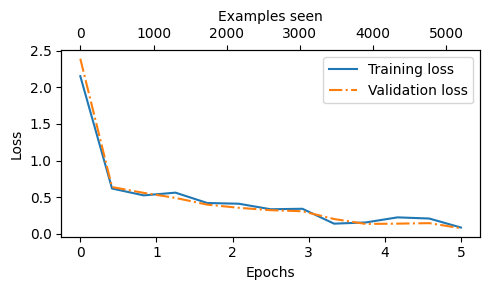

In [50]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

### Accuracy Plot

```python
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")
```

#### What to Look For

**Good Training:**
```
Accuracy
  │         ___
  │       _/
  │     _/     Training and validation both high
  │   _/
  │  /
  └──────────────── Epochs
```

**Large Train-Val Gap = Overfitting:**
```
Accuracy
  │     _______  Training (99%)
  │   _/
  │  /
  │ /    ___  Validation (80%)
  │    _/
  └──────────────── Epochs
```

If training accuracy is much higher than validation, the model is memorizing rather than learning.

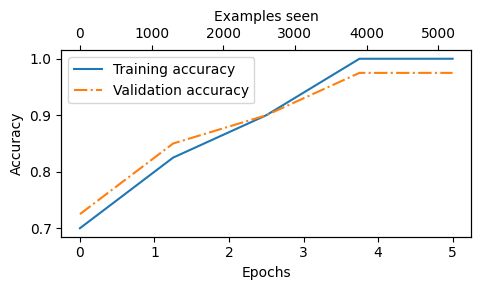

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

### Final Evaluation: The Moment of Truth

```python
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
```

#### Why All Three?

| Set | Purpose | Expected |
|-----|---------|----------|
| Training | Did model learn? | 95-99% |
| Validation | Did it generalize? | 93-97% |
| **Test** | Real-world performance | 93-97% |

**Test accuracy is the most important** - it's the unbiased estimate of real-world performance.

#### Interpreting Results

| Scenario | Diagnosis | Action |
|----------|-----------|--------|
| All ~95%+ | Great! | Deploy |
| Train 99%, Val/Test 80% | Overfitting | More regularization, less training |
| All ~60% | Underfitting | Train longer, unfreeze more layers |
| Train/Val good, Test bad | Data issue | Check test set quality |

#### Expected Results for This Task

With GPT-2 fine-tuning on spam classification:
```
Training accuracy:   97-99%
Validation accuracy: 95-97%
Test accuracy:       95-97%
```

The pre-trained model's language understanding makes spam detection "easy" - it already knows what words and patterns are suspicious!

In [52]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## Part 8: Using the Trained Model

### The Classification Function

```python
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()  # Evaluation mode
    
    # Tokenize input
    input_ids = tokenizer.encode(text)
    
    # Truncate if needed
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    
    # Pad to expected length
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    # Get prediction
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"
```

#### Why This Function is Useful

Instead of dealing with tensors and token IDs, users can simply:
```python
result = classify_review("You won $1000!", model, tokenizer, device, max_length=100)
# Returns: "spam"
```

#### The Processing Pipeline

```
"You won $1000!"
       │
       ▼ tokenizer.encode()
[1639, 1839, 720, 3064, 0]
       │
       ▼ truncate/pad
[1639, 1839, 720, 3064, 0, 50256, 50256, ...]
       │
       ▼ model()
logits: [[-1.2, 3.5]]
       │
       ▼ argmax()
1 (spam)
       │
       ▼
"spam"
```

In [53]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

### Testing on Spam Example

```python
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))
```

#### Classic Spam Indicators

The model should easily identify this as spam because of:

| Indicator | Example in Text |
|-----------|-----------------|
| Prize/money claims | "$1000 cash or a $2000 award" |
| Winner language | "You are a winner" |
| Special selection | "specially selected" |
| Too good to be true | Free money! |

#### Expected Output

```
spam
```

If the model outputs "not spam" here, something is wrong with training.

In [54]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


### Testing on Ham Example

```python
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))
```

#### Characteristics of Legitimate Messages

| Characteristic | Example in Text |
|----------------|-----------------|
| Casual greeting | "Hey" |
| Personal reference | "we're" |
| Mundane topic | Dinner plans |
| Normal request | "Let me know!" |

#### Expected Output

```
not spam
```

This is a normal, personal message with no spam indicators.

In [55]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


## Part 9: Saving the Model

### Why Save?

Training took time and compute. We save the model to:
- Use it later without retraining
- Share with colleagues or deploy
- Create checkpoints during long training runs

```python
torch.save(model.state_dict(), "review_classifier.pth")
```

#### What `state_dict()` Contains

```python
model.state_dict()
# {
#   'tok_emb.weight': tensor(...),       # Token embeddings
#   'pos_emb.weight': tensor(...),       # Position embeddings
#   'trf_blocks.0.att.W_query.weight': tensor(...),
#   ...
#   'out_head.weight': tensor(...),      # Classification head
#   'out_head.bias': tensor(...),
# }
```

All learnable parameters as a dictionary mapping names to tensors.

#### File Format

`.pth` files use Python's pickle format internally. The file size:
```
124M parameters × 4 bytes = ~500MB
```

#### Best Practices

```python
# Include model configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'config': BASE_CONFIG,
    'max_length': train_dataset.max_length,
}, "review_classifier.pth")
```

Saving config ensures you can recreate the exact architecture later.

In [56]:
torch.save(model.state_dict(), "review_classifier.pth")

### Loading a Saved Model

```python
# Load the saved state dict
model_state_dict = torch.load("review_classifier.pth", map_location=device)

# Create a fresh model with same architecture
model = GPTModel(BASE_CONFIG)

# Copy saved weights into the model  
model.load_state_dict(model_state_dict)
```

#### Why `map_location`?

Models trained on GPU save tensor locations. Loading on a different device fails without `map_location`:

```python
# Trained on GPU, loading on CPU:
torch.load("model.pth", map_location="cpu")

# Trained on CPU, loading on GPU:
torch.load("model.pth", map_location="cuda")

# Auto-detect:
torch.load("model.pth", map_location=device)
```

#### The Loading Process

1. **Load file**: Read tensor data from disk
2. **Create model**: Initialize with same architecture
3. **Copy weights**: `load_state_dict()` matches names and copies values
4. **Ready to use**: Model has trained weights!

#### Common Errors

| Error | Cause | Fix |
|-------|-------|-----|
| Missing keys | Architecture mismatch | Use same config |
| Unexpected keys | Extra layers saved | Use `strict=False` carefully |
| Size mismatch | Different dimensions | Check config exactly matches |

---

## Summary: What We Learned

1. **Fine-tuning > Training from scratch** for small datasets
2. **Freeze early layers**, train late layers + new head
3. **Data balance** is crucial for classification
4. **Monitor validation loss** to detect overfitting
5. **Small learning rates** for fine-tuning (5e-5)
6. **Save and load models** for reuse

### Next Steps

- Try different amounts of unfreezing
- Experiment with learning rates
- Test on your own datasets
- Try other classification tasks (sentiment, topic, etc.)

In [ ]:
model_state_dict = torch.load("review_classifier.pth, map_location=device")
model.load_state_dict(model_state_dict)